# Viewing the AXI4-Stream Interface

In this notebook, we will show how to visualize the timing for the interaction between the Vitis IP and processor using the AXI-Stream interface.  Before running the notebook, you should complete the steps for [running the C/RTL co-simulation](https://sdrangan.github.io/hwdesign/fifoif).  This step will create a [**Value Change Dump**](https://en.wikipedia.org/wiki/Value_change_dump)  or **VCD** file with the values for all the signals between the IP and processor.


## Parsing the VCD file


First we import the relevant packages.

In [15]:
from vcdvcd import VCDVCD
import matplotlib.pyplot as plt

We parse the VCD file using the `VCDVCD` package.  The parsed data is in the `vcd` object.

In [14]:
# Check if VCD file exists
import os
fn = os.path.join(os.getcwd(), '..', 'fifo_fun_vitis', 'vcd', 'dump.vcd')
if not os.path.exists(fn):
    raise FileNotFoundError(f"VCD file not found: {fn}")

# Parse the VCD file
vcd = VCDVCD(fn, signals=None, store_tvs=True)




The RTL simulation records traces for a large number of signals.  You can get a full list with the following command.  You will see that there are over 200 such signals.

In [16]:
nsig = len(vcd.signals)
print(f"Number of signals in VCD: {nsig}")
print(vcd.signals[:5])


Number of signals in VCD: 642
['apatb_simp_fun_top.AESL_clock', 'apatb_simp_fun_top.rst', 'apatb_simp_fun_top.dut_rst', 'apatb_simp_fun_top.start', 'apatb_simp_fun_top.ce']


In [17]:
# Find the signals with TDATA and TREADY in their names
tdatas = [s for s in vcd.signals if 'TDATA' in s]


## Plotting the AXI-Stream Interface

As described in [command-response unit](https://sdrangan.github.io/hwdesign/fifoif),
the Vitis IP has two interfaces:
* `cmd_stream`:  The AXI-Streaming slave interface for the command inputs.  It is a slave since the PS will drive the command inputs; and
* `result_stream`:  The AXI-Streaming master interface for the response outputs.  It is a master since the Vitis IP will drive the outputs.

To visualize the interaction the streaming interface, we first create a `VCDViewer` class from the package `xilinxutils` that is part of the course repository.  We, then add the clock signals along with the AXI-Stream interface signals for the two AXI-Stream interfaces.

In [68]:
import importlib

import xilinxutils
import xilinxutils.vcd
import xilinxutils.timing
importlib.reload(xilinxutils)
importlib.reload(xilinxutils.vcd)
importlib.reload(xilinxutils.timing)
from xilinxutils.vcd import VcdParser
from xilinxutils.timing import TimingDiagram

In [69]:
# Create a parsing class
vp = VcdParser(vcd)

In [70]:


# Get the clock signal name
clk_name = vp.add_clock_signal()

# Get the  AXI-Stream command signals
cmd_str_sigs, cmd_bw = vp.add_axiss_signals(name='top.cmd_stream', short_name_prefix='cmd')
print(cmd_bw)

# Get the AXI-Stream response signals
res_str_sigs, res_bw = vp.add_axiss_signals(name='top.result_stream', short_name_prefix='res')


32


We can next plot the signals.  For this purpose, the `xilinxutils` package has a simple timing diagram class, `TimingDiagram`, that can be used as follows.  It is quite basic,  so you have to play around with the parameters:

* `text_mode`:  Set to `auto` to display text only when it fits.
* `text_scale_factor`:  This factor is used to suppress text labels when they are estimated not to fit.
* `trange = [tmin,tmax]` or `None`:  Range of time to plot. `None` means the whole range will be plotted.

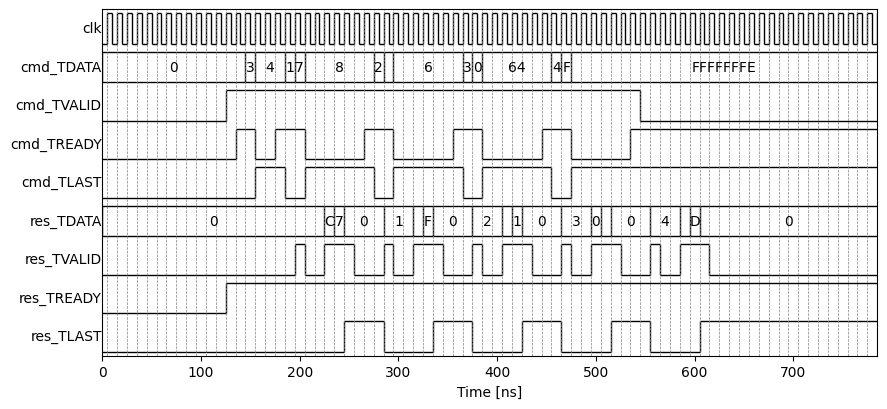

In [76]:
# Get the timing signals
sig_list = vp.get_td_signals()

# Create the timing diagram
td = TimingDiagram()
td.add_signals(sig_list)
trange = None
ax = td.plot_signals(add_clk_grid=True, trange=trange, 
                text_scale_factor=4000, text_mode='auto')
_ = ax.set_xlabel('Time [ns]')

## Analyzing the AXI-Stream Bursts
It is useful to analyze the AXI-Stream bursts in more details.  For this purpose, we can use the `extract_axis_bursts` method in the `VCDViewer` class.  

We see that we get a list, `bursts` with one item per burst.  For each burst, the dictionary `bursts[i]` has the elements:
* `beat_type`:  For each cycle in the burst, `beat_type[i]` indicates the type of beat: `0=` transfer; `1`=idle (sender not ready), `2`=stall or wait (receiver not ready)
* `data`:  List of `uint32` bit words on the beats that there was a transfer.
    * Right now, the function does not support bit widths greater than 32.
* `tstart`:  Start time of the burst in ns.

The function also returns `clk_period`.  Hence, beat `j` in burst `i` would start at time:
~~~
    bursts[i].tstart + (j-1)*clk_period
~~~

The code below extracts the bursts for the command and we see that there are five bursts -- one for each command. 

In [77]:
bursts, clk_period= vp.extract_axis_bursts(clk_name, cmd_str_sigs)

for burst in bursts:
    for k, v in burst.items():
        print(f"{k}: {v}")
    print()

data: [0 3 4]
start_idx: 13
beat_type: [0, 0, 2, 2, 0]
tstart: 135.0

data: [1 7 8]
start_idx: 18
beat_type: [0, 0, 2, 2, 2, 2, 2, 2, 0]
tstart: 185.0

data: [         2 4294967291          6]
start_idx: 27
beat_type: [0, 0, 2, 2, 2, 2, 2, 2, 0]
tstart: 275.0

data: [  3   0 100]
start_idx: 36
beat_type: [0, 0, 2, 2, 2, 2, 2, 2, 0]
tstart: 365.0

data: [         4         15 4294967294]
start_idx: 45
beat_type: [0, 0, 2, 2, 2, 2, 2, 2, 0]
tstart: 455.0



The data extracted above is represented as a list of `uint32` words.  The code below parses the data back to the command and response data structures.  We can see the fields match the testbench. 

In [78]:
import datastructs 
from xilinxutils.vitisstructs import VitisStruct

importlib.reload(datastructs)

cmd = VitisStruct('Cmd', datastructs.cmd_fields)
res = VitisStruct('Result', datastructs.resp_fields)

print('Reading command stream from VCD bursts:')
bursts, clk_period= vw.extract_axis_bursts(clk_name, cmd_str_sigs)
for burst in bursts:
    data = burst['data']
    data = data.reshape((-1, 1))
    cmd.read_stream(data)
    print(cmd.data)

print('\nReading response stream from VCD bursts:')
bursts, clk_period= vw.extract_axis_bursts(clk_name, res_str_sigs)
for burst in bursts:
    data = burst['data']
    data = data.reshape((-1, 1))
    res.read_stream(data)
    print(res.data)

Reading command stream from VCD bursts:
{'trans_id': np.int32(0), 'a': np.int32(3), 'b': np.int32(4)}
{'trans_id': np.int32(1), 'a': np.int32(7), 'b': np.int32(8)}
{'trans_id': np.int32(2), 'a': np.int32(-5), 'b': np.int32(6)}
{'trans_id': np.int32(3), 'a': np.int32(0), 'b': np.int32(100)}
{'trans_id': np.int32(4), 'a': np.int32(15), 'b': np.int32(-2)}

Reading response stream from VCD bursts:
{'trans_id': np.int32(0), 'c': np.int32(12), 'd': np.int32(7), 'err_code': <ErrCodes.NO_ERR: 0>}
{'trans_id': np.int32(1), 'c': np.int32(56), 'd': np.int32(15), 'err_code': <ErrCodes.NO_ERR: 0>}
{'trans_id': np.int32(2), 'c': np.int32(-30), 'd': np.int32(1), 'err_code': <ErrCodes.NO_ERR: 0>}
{'trans_id': np.int32(3), 'c': np.int32(0), 'd': np.int32(100), 'err_code': <ErrCodes.NO_ERR: 0>}
{'trans_id': np.int32(4), 'c': np.int32(-30), 'd': np.int32(13), 'err_code': <ErrCodes.NO_ERR: 0>}


## Viewing the Burst Timing


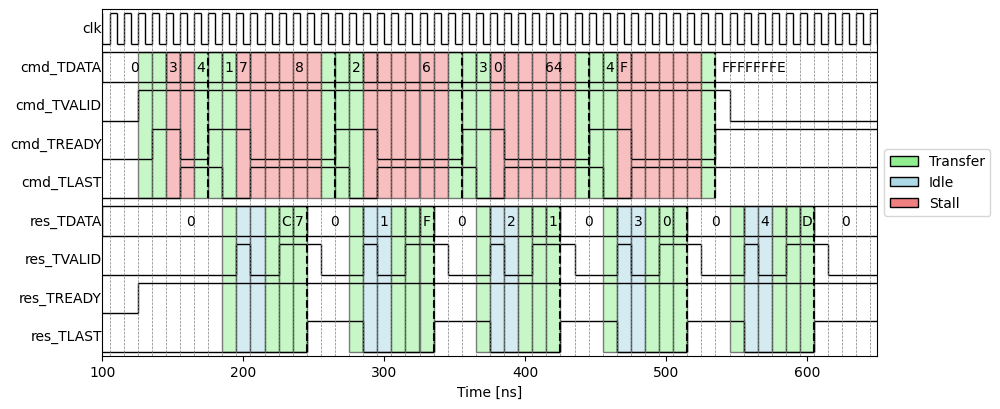

In [80]:
import matplotlib.patches as patches
from matplotlib.patches import Patch

trange = [100,650]
ax = td.plot_signals(add_clk_grid=True, trange=trange, 
                text_scale_factor=4000, text_mode='auto')
_ = ax.set_xlabel('Time [ns]')

for axis in ['cmd', 'res']:

    if axis == 'cmd':
        bursts, clk_period= vw.extract_axis_bursts(clk_name, cmd_str_sigs)
        tdat_name = 'cmd_TDATA'
        tlast_name = 'cmd_TLAST'
    else:
        bursts, clk_period= vw.extract_axis_bursts(clk_name, res_str_sigs)
        tdat_name = 'res_TDATA'
        tlast_name = 'res_TLAST'
        
    for burst in bursts:
        tstart = burst['tstart']
        nbeats = len(burst['beat_type'])

        # Check if burst is within trange
        if trange is not None:
            if (tstart < trange[0]) or (tstart + nbeats * clk_period) > trange[1]:
                continue

        for i in range(nbeats):
            beat_type = burst['beat_type'][i]
            if beat_type == 0:  # transfer. Color region in light green
                color = 'lightgreen'
            elif beat_type == 1:  # idle. Color region in light gray
                color = 'lightblue'
            elif beat_type == 2:  # stall. Color region in light coral
                color = 'lightcoral'
            t0 = tstart + (i-1) * clk_period
            t1 = tstart + i * clk_period

            ytop = td.ytop[tdat_name]
            ybot = td.ybot[tlast_name]

            # Draw a shaded region for the beat 
            rect = patches.Rectangle(xy=(t0, ybot), width=(t1 - t0), height=(ytop - ybot),
                            linewidth=1, 
                            edgecolor='black', 
                            facecolor=color, 
                            alpha=0.5)  # alpha controls shading

            ax.add_patch(rect)
            
        # Draw a vertical line at the end of the burst
        tend = tstart + (nbeats-1) * clk_period
        ax.plot([tend, tend], [ybot, ytop], color='black', linestyle='--')

# Add legend
legend_elements = [
    Patch(facecolor='lightgreen', edgecolor='black', label='Transfer'),
    Patch(facecolor='lightblue', edgecolor='black', label='Idle'),
    Patch(facecolor='lightcoral', edgecolor='black', label='Stall')
]
ax.legend(handles=legend_elements, loc='center left', bbox_to_anchor=(1, 0.5))

    